In [1]:
import pandas as pd
import numpy as np
np.random.seed(2019)


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
import scikitplot as skplt
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



##### Adult dataset is a data about employees that shows whether someone earns more then $50k or not.

##### Task is to build a model that can predict if someone can reach such high level of income. 

###### Metric of success will be an accuracy

In [2]:
#Uploading dataset and setting up a target variable
df = pd.read_hdf('train.adult.h5')
df['target'] = df['Target'].factorize()[0]

In [3]:
def draw_feature_importances(model, X, y, feats):
    '''
    Input: model you wish to train & check, data values & target variable (aka label)
    and features you have used to train the model.
    Output: Bar plot that shows which features were used the most by a model.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2019)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(accuracy_score(y_test, y_pred))
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
            color="b", align="center")
    plt.xticks(range(X.shape[1]), [feats[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [4]:
#Lets review the data
df.sample(7)

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,target
18912,24,NaN,412156,HS-grad,9,Married-civ-spouse,NaN,Wife,White,False,0,0,40,Mexico,<=50K,0
1372,43,Private,221550,Masters,14,Never-married,Other-service,Not-in-family,White,False,0,0,30,Poland,<=50K,0
19761,29,Private,114801,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,40,United-States,<=50K,0
16661,26,Private,166666,Some-college,10,Never-married,Other-service,Not-in-family,White,False,0,0,35,United-States,<=50K,0
19680,28,Private,64307,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,True,0,0,40,United-States,<=50K,0
13873,57,Private,108741,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,False,0,0,40,United-States,<=50K,0
9542,47,Private,145886,Some-college,10,Divorced,Other-service,Unmarried,White,False,0,0,40,United-States,<=50K,0


In [5]:
# Lets summarize what do we know about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 16 columns):
Age               32561 non-null int8
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null bool
Capital Gain      32561 non-null int16
Capital Loss      32561 non-null int16
Hours per week    32561 non-null int8
Country           31978 non-null object
Target            32561 non-null object
target            32561 non-null int64
dtypes: bool(1), int16(2), int64(3), int8(2), object(8)
memory usage: 3.2+ MB


There are 7 cathegorical columns that need to be transformed into integer values. This will be done by DataFrame method factorize.

In [6]:
# Deleting entries with missing data
df = df.fillna(-1)

In [7]:
#Factorizing cathegorical columns
cat_feats = df.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]
    
#Factorizing boolean values
df['Sex_Cat'] = df['Sex'].map(lambda x: int(x))

### Data Analysis

Let's check what is the data distribution. This will help us understand dependencies and allow to create new features based on exisitng columns

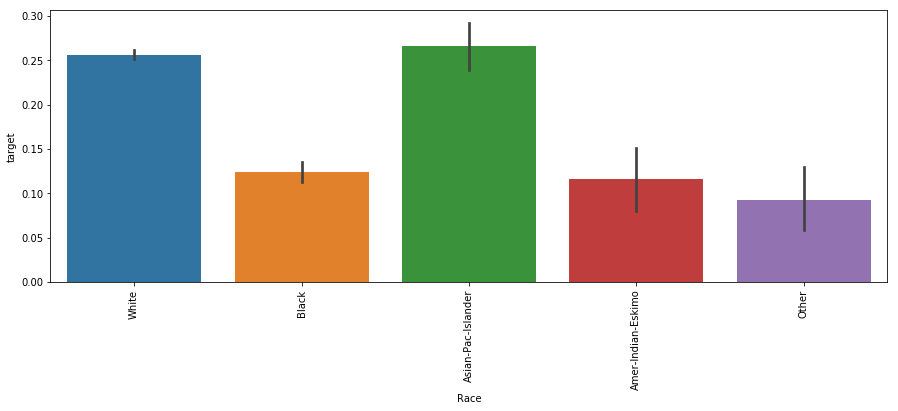

In [8]:
# Checking whether race has anything to do with hihger earnings
plt.figure(figsize=(15, 5))
sns.barplot(x="Race", y="target", data=df)
plt.xticks(rotation=90);

Plot above tells that if the person is white or asian, has 2 times higher chance for salary above 50k. Unfortunetely that looks a bit like a racism but this might be a good feature for a model.

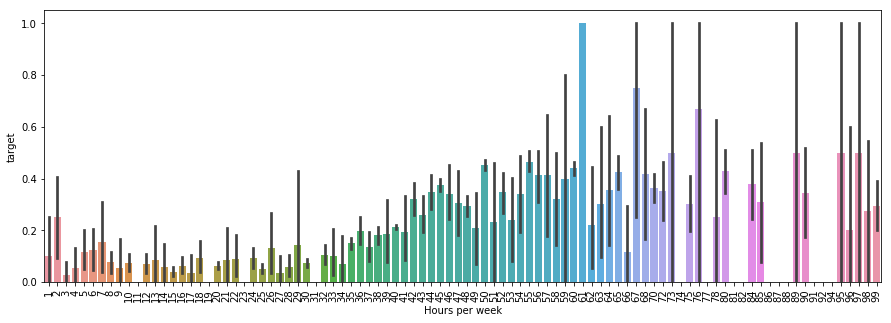

In [9]:
# Checking if higher salary depends on time you spend at work
plt.figure(figsize=(15, 5))
sns.barplot(x="Hours per week", y="target", data=df)
plt.xticks(rotation=90);

Probabilty of earnings above $50k increases for people that work longer then 35 hours/week. It's pretty expected that full time employees earn more. There are few observations with <10h per week with pretty high standard deviation and I will ignore this trend and assume it's just a data noise.

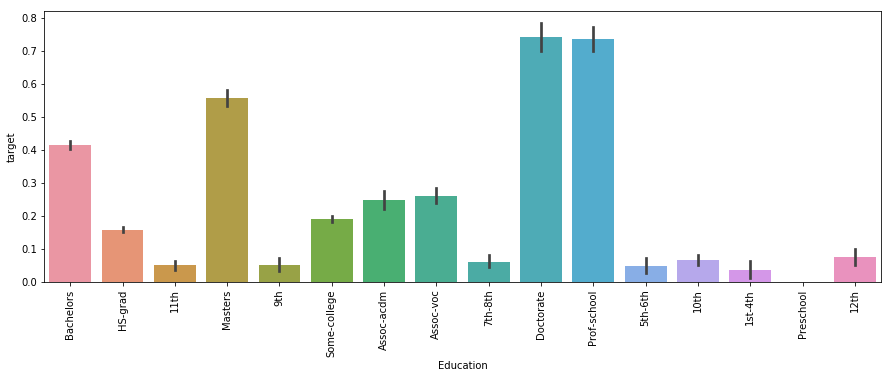

In [10]:
#Checking education dependencies
plt.figure(figsize=(15, 5))
sns.barplot(x="Education", y="target", data=df)
plt.xticks(rotation=90);

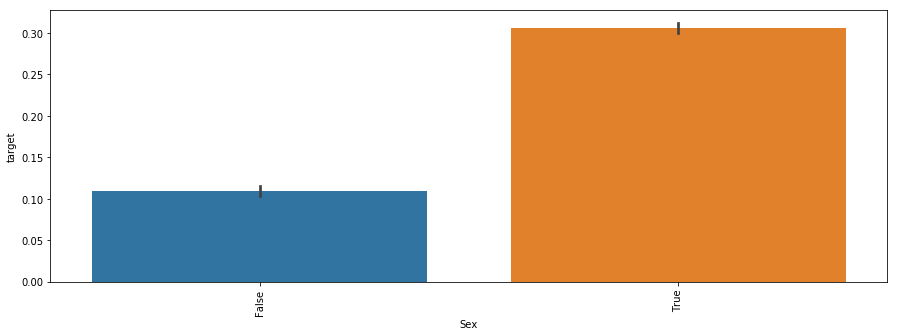

In [11]:
#Checking Sex dependencies
plt.figure(figsize=(15, 5))
sns.barplot(x="Sex", y="target", data=df)
plt.xticks(rotation=90);

False stands for a female, True for male

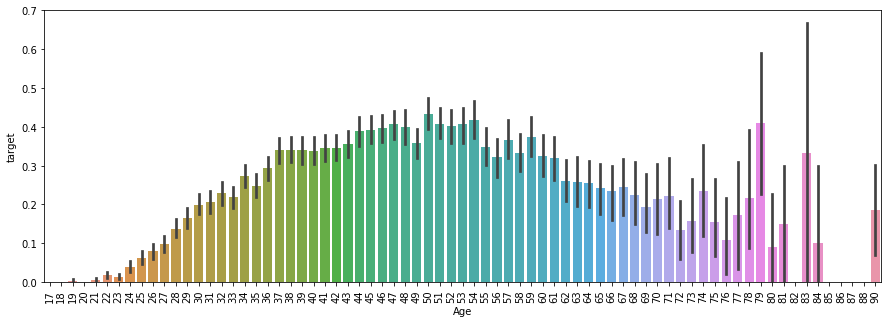

In [12]:
#Checking Age dependency
plt.figure(figsize=(15, 5))
sns.barplot(x="Age", y="target", data=df)
plt.xticks(rotation=90);

There is an obvious trend here. My new feature would be a range from 34 to 61 where the probabilty starts to decrease. Let's call it Golden Age.

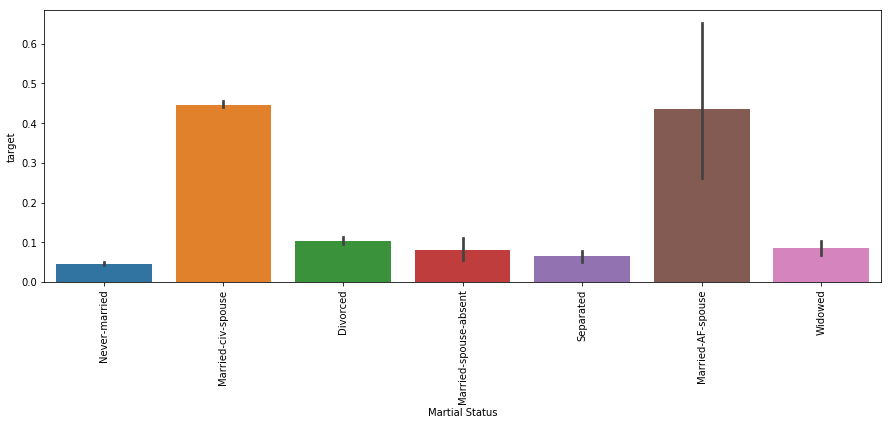

In [13]:
#Checking Martial Status dependency
plt.figure(figsize=(15, 5))
sns.barplot(x="Martial Status", y="target", data=df)
plt.xticks(rotation=90);

Data tells us that the big gains comes with marriage. This will be definitely a good feature to use

### Feature Engineering

Below I shall present two ways of creating new features. Both will use map/apply method. 

Firstly I will create dedicated functions.

Secondly I will use anonymous function syntax called lambda.

In [14]:
# Will use lambda only once just to quickly get information if a person is white race
df['Is_White'] = df['Race'].map(lambda x: int(x =='White'))

# new featuers with dedicated functions
def isWhiteMaleMarried(row):
    if row['Sex_Cat']  == 1 and row['Is_White'] == 1 and row['Relationship'] == 'Husband':
        return 1
    else:
        return 0 

df['Is_White_Husband'] = df.apply(isWhiteMaleMarried, axis=1)

def IsWhiteMale(row):
    if row['Sex_Cat']  == 1 and row['Is_White'] == 1:
        return 1
    else:
        return 0
        
df['Is_white_Male'] = df.apply(IsWhiteMale, axis=1)


def isWhiteFemaleMarried(row):
    if row['Sex_Cat']  == 0 and row['Is_White'] == 1 and row['Relationship'] == 'Wife':
        return 1
    else:
        return 0
    
df['Is_white_Wife'] = df.apply(isWhiteFemaleMarried, axis=1)


Writing dedicated function might be more clear when you combine more then 2 features. Apply method applies the function for each row in a dataset. If the conditions are met it returns 1 otherwise 0.

In [15]:
#More feature engineering with lambda

married = ["Married-AF-spouse", "Married-civ-spouse"] #if record's Martial Status is in the list I  will assume it's married.

educated = ['HS-grad', 'Some-college', 'Bachelors', 'Masters', 'Assoc-voc', 'Assoc-acdm',
            'Prof-school', 'Doctorate', 'Preschool'] #if the record edcuation status is in the list I will assume it's educated.

df['G_Age'] = df['Age'].map(lambda x: int(60>x>34))
df['Full_Time'] = df['Hours per week'].map(lambda x: int(x>42))
df['Is_from_US']= df['Country'].map(lambda x: int(x=='United-States'))
df['Is_married'] = df['Martial Status'].map(lambda x: int(x in married))
df['Is_Educated'] = df['Education'].map(lambda x: int(x in educated))
df['Is_Educated_Male'] =df.apply(lambda x: int(x['Is_Educated'] == 1 and x['Sex_Cat'] == 1), axis=1)
df['Is_Asian'] = df['Race'].map(lambda x: int(x =='Asian-Pac-Islander'))
df['Is_Asian_Male'] = df.apply(lambda x: int(x['Is_Asian'] == 1 and x['Sex_Cat'] == 1), axis=1)
df['Is_Bright'] = df.apply(lambda x: int(x['Is_Asian'] == 1 or x['Is_White'] == 1), axis=1)
df['Is_Bright_Male'] = df.apply(lambda x: int(x['Is_Bright'] == 1 and x['Sex_Cat'] == 1), axis=1)
df['Is_Self_Emp'] = df['Workclass'].map(lambda x: int(x=='Self-emp-inc'))



### Training and validation

For validation I shall use Cross Validation method. This will split data into 5 equal parts and will validate on each to make sure that final score is accurate.

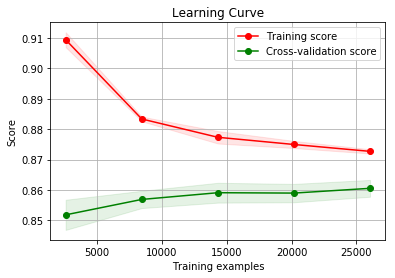

In [16]:
#### train model ####

# After 15+ iterations I have selected features below that will eventually feed the model
feats = ['Age','G_Age' ,'Education-Num', 'Sex', 'Is_married','Is_White_Husband', 'Is_white_Wife', 'Full_Time', 
         'Is_Educated', 'Is_Educated_Male', 'Occupation_cat', 'Is_Bright','Workclass_cat', 'Capital Gain', 'Capital Loss', 
         'Country_cat']


X = df[feats].values #training data
y = df['target'].values #label

model = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=2019)

# model = XGBClassifier()
scores = cross_val_score(model, X, y, cv=5)
np.mean(scores), np.std(scores)
## learning curve
skplt.estimators.plot_learning_curve(model, X, y, cv=5);

Random Forest Classifier returns the best results, approx 86% of accuracy. Score could be improved by hyperparameters optimization.

Learning curve shows that model behaves very similar on train and test data. It means that the model is not overfitted and I can expect the same accuracy  on the data that model has never seen.

In [17]:
np.mean(scores), scores, np.std(scores)

(0.8605080898494071,
 array([0.8565945 , 0.85841523, 0.86164005, 0.8622543 , 0.86363636]),
 0.002600495548121762)

Results from Cross Validation returns an average of 86% accuracy

0.8595557375371071


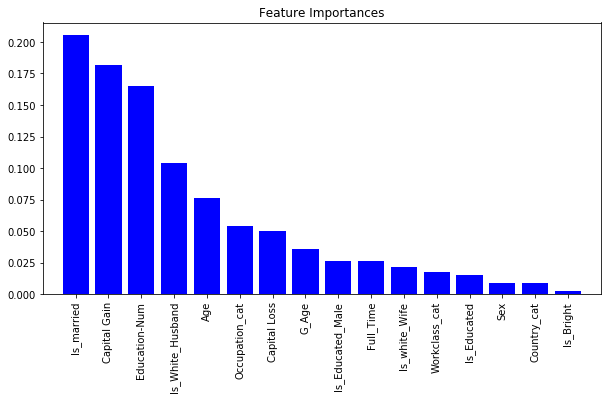

In [18]:
# Lets check which features are the most important for a model 
draw_feature_importances(model, X, y, feats)

Importance means how many times model have used feature to devide dataset and to make selection. Is_married, Capital Gain and Eduction were the most frequent feats use for split.